<a href="https://colab.research.google.com/github/yilin10/MusicalGenreClassification/blob/master/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Music Languages and System - Assignment 1

### Imports

Import of **Libraries** we need in this project

In [0]:
import numpy as np
import librosa
import os
import matplotlib.pyplot as plt
import sklearn.svm
import IPython.display as ipd
import scipy as sp
import pandas as pd

Upload of your personal **Kaggle Api token** to enable download from Kaggle

In [2]:
from google.colab import files
files.upload() # Choose kaggle.json (your personal Kaggle API token)

! rm -r ~/.kaggle
! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json # Change the permissions of the file.

Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory


Download of the dataset from Kaggle, and unzip the dataset



In [4]:
! pip install -q kaggle
! mkdir ~/dataset
! kaggle datasets download -d carlthome/gtzan-genre-collection
! unzip -q gtzan-genre-collection.zip -d ~/dataset

mkdir: cannot create directory ‘/root/dataset’: File exists
gtzan-genre-collection.zip: Skipping, found more recently modified local copy (use --force to force download)
replace /root/dataset/genres/blues/blues.00000.au? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


### Observing Data

We got the dataset from kaggle, which includes 100 pieces of 30s audio from 10 different music genres provided by GTZAN. 

All the audio tracks are sampled at 22050 Hz Mono 16-bit audio files in .au format.

And in our task we need to classify Blues, Metal, Hip-Hop, Reggae.

We can do some easy test with the audio file to get some simple solution.

- sample rate
- tempo
- ...

tbc.



## General Analysis


- do some analysis

- get overview of the four Music Genres

- draw some graph to visualise

tbc.

## Feature Selection

With the help of the Library of Pands and Numpy we are able to analysis the genral information and store the data result we need.

1. go through the genre list we are going to analysis {'blues','metal','hiphop','reggae'}
2. store the file path and the genre tag
3. extract and calculate other features we need, as **MFCC**, **Chroma_stft**
4. store result in a pandas.DataFrame structure 
5. also create a .csv file named **source_data.csv** under './source_data.csv'

## Feature Extraction

 Save source data in **genres.csv**

In [6]:
# save data in genre.csv
genre_analysis_list = ["blues","metal","hiphop","reggae"]  
genre_list = []  
path_list = []
train_path = "../root/dataset/genres/"

for each in genre_analysis_list:
    train_test_folder = train_path + format(each)
    train_catg_files = [f for f in os.listdir(train_test_folder) if f.endswith('.au')]
    for index, each_file in enumerate(train_catg_files):
        each_file_path = os.path.join(train_test_folder, each_file)
        genre_list.append(each)
        path_list.append(each_file_path)
genre_data = pd.DataFrame(list(zip(genre_list,path_list)),columns = ['Genre','Path'])
genre_data.to_csv('./genres.csv',sep = '\t', index = False)

genre_data


,Genre,Path
0,blues,../root/dataset/genres/blues/blues.00055.au
1,blues,../root/dataset/genres/blues/blues.00079.au
2,blues,../root/dataset/genres/blues/blues.00001.au
3,blues,../root/dataset/genres/blues/blues.00064.au
4,blues,../root/dataset/genres/blues/blues.00087.au
...,...,...
395,reggae,../root/dataset/genres/reggae/reggae.00041.au
396,reggae,../root/dataset/genres/reggae/reggae.00069.au
397,reggae,../root/dataset/genres/reggae/reggae.00013.au
398,reggae,../root/dataset/genres/reggae/reggae.00059.au


Extract **Mfcc** and **Chroma** as features to analysis.

Save them in pd.DataFrame and also in **'features.cs''** file.

In [0]:
# save MFCC feature in features.csv
mfcc_list = []
mfcc_value = np.zeros((400, 13))
chroma_value = np.zeros((400, 12))

columns =[]
for mfcc_i in range(0,13):
    columns.append('mfcc'+str(mfcc_i))

for each_file, index in zip(genre_data['Path'],range(0,400)):
    y, sr = librosa.load(each_file)
    print("Now processing:",each_file)
    # get feature mfcc
    features_mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13) 
    mfcc_value[index,:] = np.mean(features_mfcc,axis=1)
    
    # get feature chroma
    features_chroma = librosa.feature.chroma_stft(y,sr)
    chroma_value[index, :] = np.mean(features_chroma, axis=1)
    
    # test print
    print("MFCC: ", mfcc_value)
    print("Chroma: ", chroma_value)


# feature_table is the df of mfcc_value
features_value = pd.DataFrame(mfcc_value)
# add other feature, chroma also inside this table

# test
#print(pd.concat([feature_table, pd.DataFrame(chroma_value)], axis=1))

# update features_value and save to .csv
features_value = pd.concat([features_value, pd.DataFrame(chroma_value)], axis=1)

# update the features_value dataframe column name to mfcc1 to mfcc13, chroma 1 to 12
col_name = []
for index in range(0,13):
    col_name.append('mfcc'+str(index+1))
for index in range(0,12):
    col_name.append('chroma'+str(index+1))
# print(col_name)
features_value.columns = col_name
# save to .csv
features_value.to_csv('./features.csv',sep = '\t', index = False)

    



Here we can print the result to check.

In [8]:
# print test
print(features_value.head(10))
print(features_value.columns)
print(features_value.index)

features_value.columns = col_name
print(features_value.head(1))

        mfcc1       mfcc2      mfcc3  ...  chroma10  chroma11  chroma12
0  -98.743446  104.793649 -35.098252  ...  0.405270  0.413129  0.409829
1   -3.554832   92.920883 -25.078385  ...  0.340804  0.622766  0.403871
2 -207.501685  123.991259   8.955128  ...  0.255178  0.285020  0.334202
3  -85.108766   88.799706 -16.312861  ...  0.324397  0.197179  0.292285
4 -155.558833  125.645326   1.601123  ...  0.394358  0.337228  0.259450
5  -55.607545  114.931618 -37.031946  ...  0.387273  0.382057  0.387459
6  -38.974173  112.064238 -31.822337  ...  0.336733  0.581366  0.389381
7  -86.237156   91.961270 -23.417448  ...  0.394080  0.408509  0.384115
8  -82.505001   94.153384 -27.101466  ...  0.560045  0.492593  0.508022
9 -148.640408  145.781913  -9.368233  ...  0.360723  0.350167  0.434200

[10 rows x 25 columns]
Index(['mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8',
       'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'chroma1', 'chroma2',
       'chroma3', 'chroma4'


## Data Spliting

What's the benefit about data spliting,

1. By dividing the data set according to a certain ratio, we can reasonably evaluate the performance of the learning algorithm in the face of unknown data.

2. If the data used to evaluate the model is not independent of the sample, the evaluation result may be inaccurate. We also want this model can be applied in a wider range of situations.



The simple way to do the data spliting is to use *sklearn.model_selection.train_test_split* to split to **Training set** and **Testing set**.


In [0]:
# sklearn provides the function to split data
# use to split dataset into train and test
# X for features
# Y for labels = target value = the genre info

from sklearn.model_selection import train_test_split
# get the features
features = features_value

# get only the labeled genre result
result = genre_data['Genre']

# Use sklearn.train_test_split to split 80 % for training and 20% for testing
# the random seed is set to 22 here in order to see a fixed output based on this.
for each in genre_analysis_list:
    X_train, X_test,y_train,y_test = train_test_split(
        features, result,
        test_size = 0.2,
        random_state = 22, shuffle = True)

Print the test result to check.

In [12]:
# Test
print(len(X_test))
print(len(X_train))
print(len(y_test))
print(len(y_train))
print(X_test)
print("This should be the test label")
y_test


80
320
80
320
          mfcc1       mfcc2      mfcc3  ...  chroma10  chroma11  chroma12
261  -61.832633   72.133410 -16.303716  ...  0.531837  0.480454  0.353046
393 -136.731307   75.612379  -5.324862  ...  0.383879  0.433059  0.334671
378  -70.058141   54.370973  15.569383  ...  0.401825  0.378737  0.493767
185  -79.054297  106.825289 -38.750370  ...  0.257664  0.335813  0.388003
202  -76.681586   52.775764  34.632839  ...  0.443574  0.377601  0.379180
..          ...         ...        ...  ...       ...       ...       ...
201 -191.622116   41.312495   5.009900  ...  0.447420  0.442953  0.442936
32  -228.167085  130.339664 -23.310708  ...  0.214505  0.331917  0.561496
204  -44.298638   93.361235 -22.289666  ...  0.616870  0.504237  0.437813
264  -78.819770   51.530024  42.267741  ...  0.329076  0.301430  0.316920
186   26.711792   79.789431 -52.051777  ...  0.664164  0.578439  0.439954

[80 rows x 25 columns]
This should be the test label


261    hiphop
393    reggae
378    reggae
185     metal
202    hiphop
        ...  
201    hiphop
32      blues
204    hiphop
264    hiphop
186     metal
Name: Genre, Length: 80, dtype: object

Seconderly, another way to do the spliting, is to use **K-fold cross validating** method.

The advantage of applying this method:

1. we only have 400 audio piece in total, it's realatively a small amout of sample
2. to make the future model more accurate


**K-fold cross-validation** to do the selecting for the best parameter for the future model in order to increase the accuary dealing with unseen data.


The workflow in this part should be like this,
<div>
<img src="https://scikit-learn.org/stable/_images/grid_search_workflow.png" width="500"/>
</div>

The general procedure for Cross-Validating is:

1. Shuffle the dataset randomly.
2. Split the dataset into k groups
3. For each unique group:
    - Take the group as a hold out or test data set
    - Take the remaining groups as a training data set
    - Fit a model on the training set and evaluate it on the test set
    - Retain the evaluation score and discard the model
    - Summarize the skill of the model using the sample of model evaluation scores

**Reference**
1. [Wiki](https://en.wikipedia.org/wiki/Cross-validation_(statistics))
2. [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html)

## Cross Validating

In [0]:
%matplotlib

sklearn.model_selection.cross_validate(

..

something




## Observing the Training Set

We can visusalise the feature we want to use from the splited subset X_train.

tbc.

## Training

As for classifier, we can try different approaches, 

as **K Neighbour Classfier**, **Support Vector Classifier** or others.

We can test each model with the already splited dataset and try to find the best parameters to see the best result they could have.

### 0. KNN

The parameters for KNN Classifier are **searching algorithm**, **n_neighbors**, **weights** and **p** (the way to calculate distance)

Here is a simple test example using the dataset we have.

In [15]:
from sklearn import neighbors, datasets
from sklearn.neighbors import NearestNeighbors
kClassifier = neighbors.KNeighborsClassifier(n_neighbors=15,weights = 'distance')
kClassifier.fit(X_train,y_train)

predictedTestLabels = kClassifier.predict(X_test)
  
print(kClassifier.score(X_test,y_test))

0.675


We can try to find a better k and weight to get higher score.


For the **algorithm**, we can just choose **'auto'**, since this method would choose the fatest method from the other three, 'brute', 'kd_tree', 'ball_tree'.

But for k and p, we will just enumerate all the combinations of different parameter set to check which has the highest score. 

(Is this called Grid Search to get the best parameter set?)


Here is to search for the best **k** only.

In [17]:
best_method = ""
best_score = 0.0
best_k = -1
for method in ["uniform", "distance"]:
    for k in range(1, 11):
        knn_clf = neighbors.KNeighborsClassifier(n_neighbors = k)
        knn_clf.fit(X_train, y_train)
        knn_score = knn_clf.score(X_test, y_test)
        if knn_score > best_score:
            best_score = knn_score
            best_k = k
            best_method = method

print("searching better parameter...")
print("best_method = ", best_method)
print("best_k = ", best_k)
print("best_score = ", best_score)

searching better parameter...
best_method =  uniform
best_k =  3
best_score =  0.7375


Also searching a better **k** with **p**



In [19]:
%%time
best_p = -1
best_score = 0.0
best_k = -1
for k in range(1, 11):
    for p in range(1, 6):
        knn_clf = neighbors.KNeighborsClassifier(n_neighbors = k, weights = "distance", p = p)
        knn_clf.fit(X_train, y_train)
        knn_score = knn_clf.score(X_test, y_test)
        if knn_score > best_score:
            best_score = knn_score
            best_k = k
            best_p = p

print("best_p = ", best_p)
print("best_k = ", best_k)
print("best_score = ", best_score) 

best_p =  1
best_k =  1
best_score =  0.75
CPU times: user 630 ms, sys: 1.08 ms, total: 631 ms
Wall time: 632 ms


**Confusion Matrix**

So up to now, the best parameter for current KNN model should use **k = 3, p =1**.

We can get the percentage of the accuracy for the prediction result,then together with the genre label of the testdata we can plot the **Confusion Matrix** as followed.

Each **row** in the matrix is the real genre, while each **column** is the predicted genre category classified by the model we build.

From the result of this Confusion Matrix, we can clearly see that the only music genre that has been difficult for our KNN model to classify is the "Regea". The result shows that the accuracy rate is only 0.48. And 0.43 has been put in the wrong genre a "metal".


[[0.7        0.05       0.1        0.15      ]
 [0.04545455 0.68181818 0.09090909 0.18181818]
 [0.05882353 0.05882353 0.88235294 0.        ]
 [0.0952381  0.42857143 0.         0.47619048]]


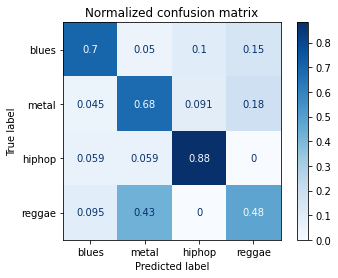

In [25]:
from sklearn.metrics import plot_confusion_matrix
# plot confusion matrix
title = "Normalized confusion matrix"
disp = plot_confusion_matrix(kClassifier,X_test, y_test,
                                 display_labels=genre_analysis_list, # genre names list
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title(title)

print()
print(disp.confusion_matrix)

plt.show()

### 1. SVC: Support Vector Classifier

using sklearn [SVM](https://scikit-learn.org/stable/modules/svm.html#classification)

In this part, we can use the simplest svm to get get prediction of the music genre using test data.

In [75]:
from sklearn import svm
X = X_train #feature training data
Y = y_train # genre
clf = svm.SVC(decision_function_shape='ovo')

# the predicted result
clf.fit(X, Y)
print(clf.predict(X_test))

# check the score of the predicted result
print(clf.score(X_test,y_test))


['hiphop' 'reggae' 'hiphop' 'metal' 'hiphop' 'metal' 'metal' 'blues'
 'reggae' 'reggae' 'metal' 'metal' 'hiphop' 'metal' 'metal' 'metal'
 'blues' 'reggae' 'blues' 'blues' 'metal' 'hiphop' 'reggae' 'metal'
 'reggae' 'hiphop' 'hiphop' 'reggae' 'hiphop' 'hiphop' 'blues' 'metal'
 'blues' 'metal' 'hiphop' 'hiphop' 'blues' 'hiphop' 'blues' 'reggae'
 'metal' 'metal' 'metal' 'reggae' 'metal' 'metal' 'hiphop' 'hiphop'
 'hiphop' 'metal' 'blues' 'blues' 'reggae' 'blues' 'reggae' 'blues'
 'metal' 'metal' 'metal' 'metal' 'reggae' 'hiphop' 'hiphop' 'blues'
 'blues' 'hiphop' 'blues' 'metal' 'hiphop' 'metal' 'hiphop' 'metal'
 'metal' 'blues' 'reggae' 'reggae' 'blues' 'metal' 'hiphop' 'metal']
0.65


Plot the prediction result and the difference between the test result.


In [0]:
from sklearn.metrics import classification_report

Y_predict

### 2. NN


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import optimizers

model = Sequential()

model.add(Dense(256,input_shape=[None,10,25],activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(10,activation='softmax'))

adam = optimizers.Adam(lr=0.0001)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam,
              metrics=['acc'])

history = model.fit(X_train,y_train,
                    batch_size=10,
                    epochs=100,
                    validation_data=(X_test,y_test))

In [0]:
! pip uninstall tensorflow

! pip install tensorflow= 1.4.0
import tensorflow as tf

x = tf.placeholder(tf.float32, [None, 28])
y = tf.placeholder(tf.int32, [None])


# Fully connected layer
layer1 = tf.contrib.layers.fully_connected(X_train, 100, tf.nn.tanh)
layer2 = tf.contrib.layers.fully_connected(layer1, 85, tf.nn.tanh)
layer3 = tf.contrib.layers.fully_connected(layer2, 90, tf.nn.tanh)
layer4 = tf.contrib.layers.fully_connected(layer3, 10, tf.nn.relu)

# Define a loss function
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y,
                                                                    logits = layer4))

# Define an optimizer
train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)


# Convert logits to label indexes
correct_pred = tf.equal(tf.argmax(layer4, 1), tf.cast(y, tf.int64))

# Define an accuracy metric
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

tf.set_random_seed(1234)
sess = tf.Session()

sess.run(tf.global_variables_initializer())

for i in range(1500):
        print('EPOCH', i)
        _, accuracy_val = sess.run([train_op, loss], feed_dict={x: X_train, y: y_train})
        if i % 10 == 0:
            print("Loss: ", accuracy_val)
        print('DONE WITH EPOCH')
print(sess.run(accuracy, feed_dict={x: X_train, y: y_train}))


# predicted = sess.run([accuracy], feed_dict={x: X_test})[0]
# print(predicted)

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.layers import Input, Dense
import tensorflow.python.keras



inputs = X_train
lstm = tf.keras.layers.LSTM(4)

output = lstm(inputs)  # The output has shape `[32, 4]`.

lstm = tf.keras.layers.LSTM(4, return_sequences=True, return_state=True)

# whole_sequence_output has shape `[32, 10, 4]`.
# final_memory_state and final_carry_state both have shape `[32, 4]`.
whole_sequence_output, final_memory_state, final_carry_state = lstm(inputs)

## Testing


## Evaluation

## Optimization


https://scikit-learn.org/stable/modules/grid_search.html#grid-search

In [0]:
# use param_grid
# estimator.get_params()
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

## Final Conclusion

## * Playground 1(Test 0410 )

## * Playground 2(Feature Extracting Single Test)

This part is just the first attempt to get some features from dataset. 

Not useful anymore.

we are goint to extract some features using librosa library.

1. Feature Selecting
- **mfcc**: librosa.feature.mfcc, num =13
- **chroma**: num = 12
- tempogram: librosa.feature.tempogram
- melspectrogram: librosa.feature.melspectrogram


2. Feature extracting: **mfcc**

In [0]:
dict_train_features_mfcc = {"blues": [], "metal": [], "hiphop": [], "reggae": []}

n_mfcc = 13 
# try: change back to 13
train_path = "../root/dataset/genres/"

for each in genre_analysis_list:
    train_test_folder = train_path + format(each)
    #the current folder/categories
    print("Current train_test_folder is: " + train_test_folder)

    train_catg_files = [f for f in os.listdir(train_test_folder) if f.endswith('.au')]
    #print(train_catg_files)
    n_train_samples = len(train_catg_files) 
    #how much files in each category
    print("Number of training samples in this category: ", n_train_samples)
    
    #store feature result
    train_features = np.zeros((n_train_samples, n_mfcc))
    
    #print(train_features)
    for index, each_file in enumerate(train_catg_files):
        each_file_path = os.path.join(train_test_folder, each_file)
        y, sr = librosa.load(each_file_path)
        
        feature_mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13) 
        train_features[index, :] = np.mean(feature_mfcc, axis=1)

    dict_train_features_mfcc[each] = train_features
    print(dict_train_features_mfcc)


Current train_test_folder is: ../root/dataset/genres/blues
Number of training samples in this category:  100
{'blues': array([[-121.44897818,   96.08053754,  -19.58984207, ...,  -19.98377236,
           6.80231743,  -19.32695874],
       [-121.36393978,  122.50668278,  -14.73819649, ...,   -6.71836617,
           6.9925423 ,  -12.73059788],
       [ -30.09818726,  103.73251787,  -19.73797114, ...,  -11.64942145,
          11.21639169,   -8.83841749],
       ...,
       [-155.55883299,  125.64532595,    1.60112256, ...,   -6.66125909,
          -0.79785444,   -7.74170066],
       [-145.28097158,  102.80664883,  -12.52943294, ...,   -6.9347002 ,
           7.45876939,  -10.468453  ],
       [ -52.69724745,   74.43335905,  -18.69676666, ...,   -9.24894607,
           7.78540358,  -10.56844782]]), 'metal': [], 'hiphop': [], 'reggae': []}
Current train_test_folder is: ../root/dataset/genres/metal
Number of training samples in this category:  100
{'blues': array([[-121.44897818,   96.0805375

Check to see mfcc data

In [0]:
print(dict_train_features_mfcc)

{'blues': array([[-121.44897818,   96.08053754,  -19.58984207, ...,  -19.98377236,
           6.80231743,  -19.32695874],
       [-121.36393978,  122.50668278,  -14.73819649, ...,   -6.71836617,
           6.9925423 ,  -12.73059788],
       [ -30.09818726,  103.73251787,  -19.73797114, ...,  -11.64942145,
          11.21639169,   -8.83841749],
       ...,
       [-155.55883299,  125.64532595,    1.60112256, ...,   -6.66125909,
          -0.79785444,   -7.74170066],
       [-145.28097158,  102.80664883,  -12.52943294, ...,   -6.9347002 ,
           7.45876939,  -10.468453  ],
       [ -52.69724745,   74.43335905,  -18.69676666, ...,   -9.24894607,
           7.78540358,  -10.56844782]]), 'metal': array([[-201.1456495 ,   76.78046651,  -14.79818326, ...,  -11.07651057,
          15.56745048,  -11.1910169 ],
       [ -96.61267804,  101.73752417,  -16.84916514, ...,  -14.61175134,
          15.23600147,  -16.01568229],
       [  26.71179151,   79.78943063,  -52.05177714, ...,  -12.18792587

In [0]:
for each in dict_train_features_mfcc:

    pdmfcc = pd.DataFrame(dict_train_features_mfcc[each])
    print("Current: ",each)
    print("\n",pdtest)
    # add to dataframe
source_data['mfcc'] = pdmfcc
print(source_data)
# df['Address'] = address 
    #pdtest.to_csv("source_data.csv")

Current:  blues

             0           1          2   ...        10         11        12
0  -159.901509   92.846874 -28.743676  ...  3.563651   0.327645  8.555529
1   -91.421028   98.796948 -23.190109  ... -8.200930  13.416365 -6.498540
2  -162.477359   98.506938  -1.643815  ... -0.870156   4.116955  3.419449
3  -177.520109   98.311107  14.755117  ...  3.544467  -0.351910  0.571039
4  -226.402402  103.326174   0.123678  ... -3.015425  11.099071  1.781853
..         ...         ...        ...  ...       ...        ...       ...
95 -120.302439   16.411487  25.025099  ...  1.904856   2.676287  2.016880
96 -115.707166   67.075646   1.873526  ...  7.597496   4.998960  8.534348
97 -177.728037  113.607273   2.342382  ... -2.061071  13.126954 -7.249082
98 -134.570367   93.526827   8.514837  ...  5.070638  11.864220  4.421660
99  -97.746883  108.831239 -24.916161  ... -9.666188   4.267922  2.461585

[100 rows x 13 columns]
Current:  metal

             0           1          2   ...        1

ValueError: ignored

3. Feature extracting: **chroma**

In [0]:
dict_train_features_chroma = {"blues": [], "metal": [], "hiphop": [], "reggae": []}
for each in ana_class:
    train_test_folder = train_path + format(each)
    print("Current train_test_folder is: " + train_test_folder) #current folder
    train_catg_files = [f for f in os.listdir(train_test_folder) if f.endswith('.au')]
    n_train_samples = len(train_catg_files)
    n_size = 12
    train_features = np.zeros((n_train_samples,n_size)) # 12

    for index, each_file in enumerate(train_catg_files):
        each_file_path = os.path.join(train_test_folder, each_file)
        y, sr = librosa.load(each_file_path)
        #new feature
        feature_chroma = librosa.feature.chroma_stft(y,sr)
        train_features[index, :] = np.mean(feature_chroma, axis=1)

    dict_train_features_chroma[each] = train_features
#Test
print("---\n Testing...")
print(dict_train_features_chroma["blues"])

In [0]:
pd = pandas.DataFrame(dict_train_features_chroma)
pd.to_csv("test.csv")

3. Feature extracting: **tempogram** 

    Not using this feature right now, as I am not sure. There might be some problems with the window length need to be fixed.





**Function calculate_features**

Define a function calculate any feature we want by walking through the file of specific genres.

In [0]:
def calculate_feature(categories = ["blues","metal","hiphop","reggae"] ,something):
    """

    """
    

    return dict_feature

## Playground 3(Feature Extraction)

In [0]:
train_path = "../root/dataset/genres/"
genre_list = []
path_list = []
mfcc_list = []
chroma_list= []

# The list of genres we need to analysis
genre_analysis_list = ["blues","metal","hiphop","reggae"]    

# Go throug the file of each genre
for each in genre_analysis_list:
    train_test_folder = train_path + format(each)
    # To see current folder of this genre
    print("Current train_test_folder is: " + train_test_folder)

    train_catg_files = [f for f in os.listdir(train_test_folder) if f.endswith('.au')]
    
    train_features = np.zeros((100, 13)) #define n_mfcc =13
    train_features_c = np.zeros((100, 12)) 
    for index, each_file in enumerate(train_catg_files):
        # get file_path
        each_file_path = os.path.join(train_test_folder, each_file)
        # get y, sample rate
        y, sr = librosa.load(each_file_path) 
        # calculate mfcc, num = 13, store in train_features
        feature_mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13) 
        train_features[index, :] = np.mean(feature_mfcc, axis=1)
        # calculate chroma, num =12
        features_chroma = librosa.feature.chroma_stft(y,sr)
        train_features_c[index, :] = np.mean(features_chroma, axis=1)

        # Add to list to store
        genre_list.append(each)
        path_list.append(each_file_path)
        mfcc_list.append(train_features[index])
        # Add feature chroma
        chroma_list.append(train_features_c[index])


# Create a new Pandas Data Frame to store the result
# With Column: "Genre", "File_path", "Est_tempo"
# can also add f1, f2 ... other features
source_data = pd.DataFrame(
    list(zip(genre_list,path_list)), #path_list
               columns =['Genre', 'File_path']) 

source_data['MFCC'] =  mfcc_list    
source_data['Chroma'] =  chroma_list  
# Export the dataframe we need to a csv file 
source_data.to_csv('./source_data.csv', sep = '\t', index=False)

In [0]:
# Test print
print("Test ---")
print(source_data)

print(source_data['MFCC'])


We can also download the **'source_data.csv'** to check.

Thus, we need to split the data into two part( 80% : 20%) in order to have totally different data with labels for training and testing individually.

And now we have two choosen features, mfcc(num=13), chroma(num=12) to deal with.

From the test, we can see the whole dataset has been splited into two subset, one is **X_train** for training our model, the other is **X_test** for testing. 

The **y_train**, and y_test is the value of music genres(the label we have).

This part is just playing with pandas.

Not useful anymore

---


In [0]:
audio_piece = {'Genre': ['blues','metal','hiphop','reggae'],
        'Path': ['a','b','c','d']
        }

df = pd.DataFrame(audio_piece, columns= ['Genre', 'Path'])

print (df)
audio =['a','file_path',3]
d = pd.DataFrame(audio,columns=['name','path'])
print(d)

play with a simple audio file

In [0]:
path = "../root/dataset/genres/blues/blues.00000.au"
y, sr = librosa.load(path) # samplerate
#c_path = librosa.util.example_audio_file()
#sample_rate = librosa.get_samplerate(c_path)

tempo, beat_frames = librosa.beat.beat_track(y, sr)

f_mfcc = librosa.feature.mfcc(y, sr)
duration = librosa.get_duration(y, sr)
rms = librosa.feature.rms(y)
mels = librosa.feature.melspectrogram(y,sr) #calculate the melspectrogram
spt_flat = librosa.feature.spectral_flatness(y)
feature_tempogram = librosa.feature.tempogram(y, sr,10)
feature_chroma = librosa.feature.chroma_stft(y,sr)

print("current file: ", path, "with sample rate: ", sr) # 
#print("y = ", y)
print('The Estimated tempo is : {:.2f} beats per minute'.format(tempo))
print("mfcc = ", f_mfcc)
print("The duration of the file is: ", duration, "in seconds")
print("RMS: ", rms)
print("MELS: ", mels)
print("Spectral Flatness:", spt_flat)
print("len of Spectral Flatness:", len(spt_flat))
print("feature_tempogram:",feature_tempogram)
print("len of feature_tempogram:", len(feature_tempogram))

print("feature_chroma:",feature_chroma)
print("len of feature_chroma:", len(feature_chroma))



What we can get from the sample audio file as **general information**,
1. basic info: sample rate, duration of the file, estimated tempo
2. low level feature info:
    - mfcc (recognition)
    - melspectrogram
    - spectral_flatness (tonal)
3. high level feature info {consist of low level features}


Using the four categories {Blues, Metal, Hip-hop, Reggae} as instructed.

In [0]:
#we need to analysis Blues, Metal, Hip-Hop, Reggae
ana_class = ["blues","metal","hiphop","reggae"] 
dict_train_features = {"blues": [], "metal": [], "hiphop": [], "Reggae": []}
n_mfcc = 20
# try: change back to 13
train_path = "../root/dataset/genres/"


for each in ana_class:
    train_test_folder = train_path + format(each)
    #the current folder/categories
    print("Current train_test_folder is: " + train_test_folder)

    train_catg_files = [f for f in os.listdir(train_test_folder) if f.endswith('.au')]
    #print(train_catg_files)
    n_train_samples = len(train_catg_files) 
    #how much files in each category
    print("Number of training samples in this category: ", n_train_samples)
    
    #store feature result
    train_features = np.zeros((n_train_samples, n_mfcc))
    
    #print(train_features)
    for index, each_file in enumerate(train_catg_files):
        each_file_path = os.path.join(train_test_folder, each_file)
        y, sr = librosa.load(each_file_path)
        feature_mfcc = librosa.feature.mfcc(y, sr)
        train_features[index, :] = np.mean(feature_mfcc, axis=1)
        #print("train_features", train_features)
        #dont need tempo in this way, for now...
        #tempo, beat_frames = librosa.beat.beat_track(y, sr)
        #print("Estimated tempo: ", tempo)

    dict_train_features[each] = train_features
    print(dict_train_features["blues"])

Current train_test_folder is: ../root/dataset/genres/blues
Number of training samples in this category:  100
[[-1.21448978e+02  9.60805375e+01 -1.95898421e+01 ... -2.04378116e+00
  -1.76269026e+00 -3.96245312e+00]
 [-1.21363940e+02  1.22506683e+02 -1.47381965e+01 ...  2.69524786e+00
   3.41230547e+00 -2.71569238e+00]
 [-3.00981873e+01  1.03732518e+02 -1.97379711e+01 ...  4.72184211e+00
   4.90646799e-01  1.47166699e+00]
 ...
 [-1.55558833e+02  1.25645326e+02  1.60112256e+00 ...  9.69413886e-01
   2.02691569e+00 -5.73704447e+00]
 [-1.45280972e+02  1.02806649e+02 -1.25294329e+01 ... -9.52051838e-01
   2.25845906e-02 -2.00456166e+00]
 [-5.26972475e+01  7.44333591e+01 -1.86967667e+01 ...  3.68983828e+00
  -4.93847515e+00  4.42173063e+00]]
Current train_test_folder is: ../root/dataset/genres/metal
Number of training samples in this category:  100
[[-1.21448978e+02  9.60805375e+01 -1.95898421e+01 ... -2.04378116e+00
  -1.76269026e+00 -3.96245312e+00]
 [-1.21363940e+02  1.22506683e+02 -1.4738

**Visulise the features of MFCC**


Something seems wrong...

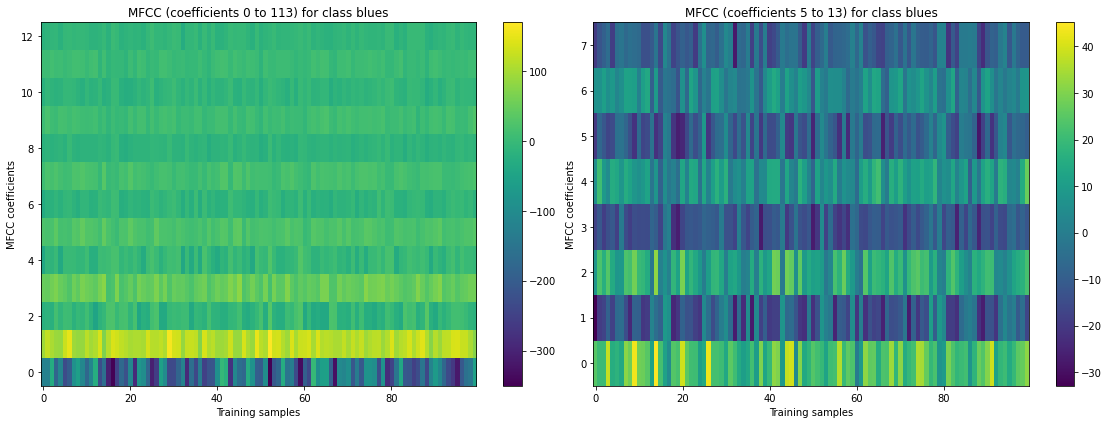

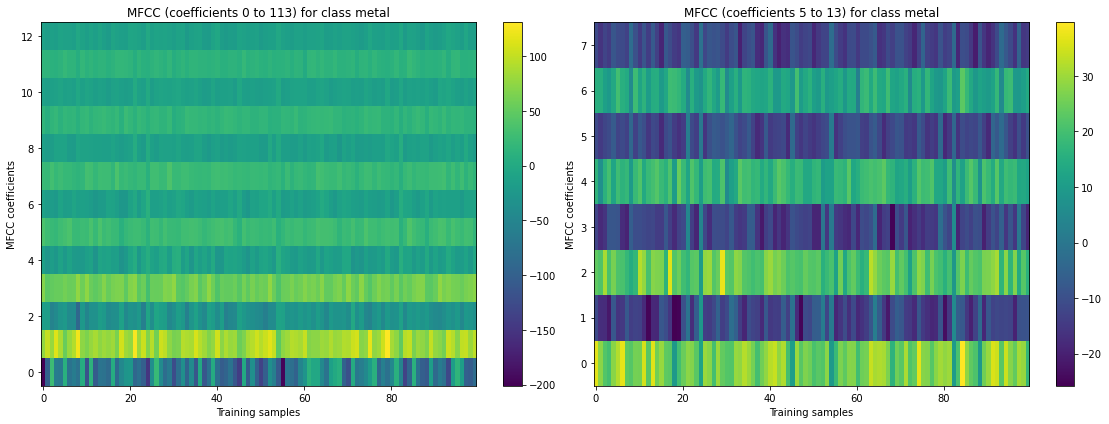

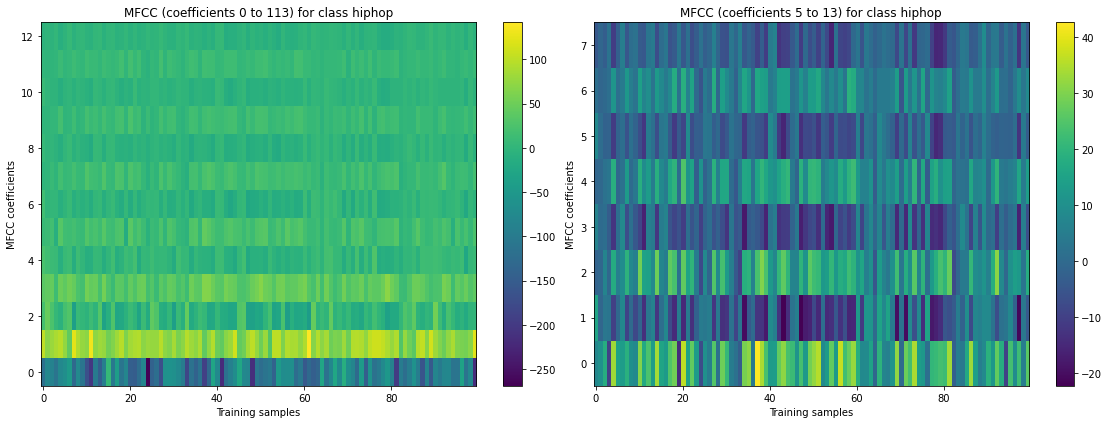

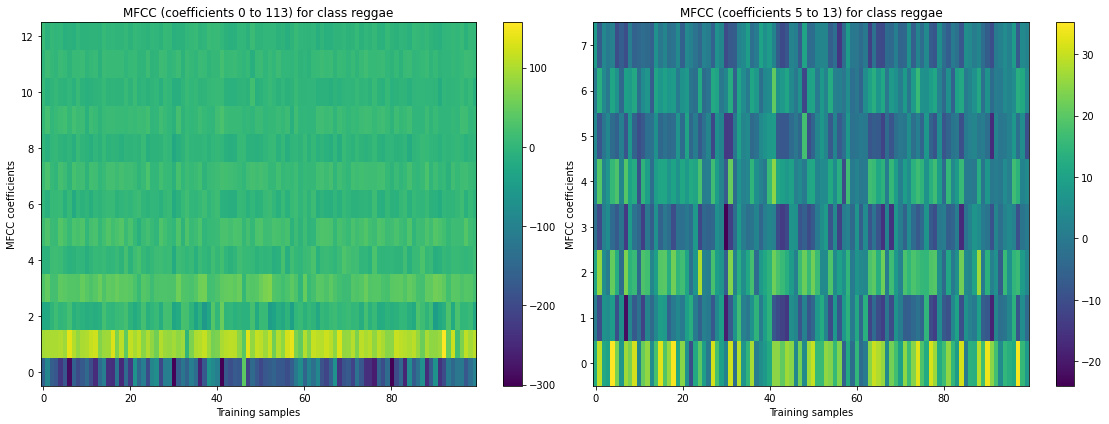

In [0]:
for each in ana_class:
    mfcc = dict_train_features_mfcc[each].transpose()
    
    # Visualization
    figure = plt.figure(figsize=(16, 6))
    plt.subplot(1,2,1)
    plt.imshow(mfcc, origin='lower', aspect='auto')
    plt.xlabel('Training samples')
    plt.ylabel('MFCC coefficients')
    plt.title('MFCC (coefficients 0 to 113) for class {}'.format(each))
    plt.colorbar()
    plt.tight_layout()

    mfcc_upper = mfcc[5:]
    plt.subplot(1,2,2)
    plt.imshow(mfcc_upper, origin='lower', aspect='auto')
    plt.title('MFCC (coefficients 5 to 13) for class {}'.format(each))
    plt.xlabel('Training samples')
    plt.ylabel('MFCC coefficients')
    plt.colorbar()
    plt.tight_layout()

## Playground 4(SVC)


In [0]:
sklearn.svm.SVC()

NameError: ignored

## About Team Work
**0410 Discussion**
1. apply preprocessing to audio files
2. how to split our dataset to {training, testing} to make sure the difference of the two groups
3. check if our dataset is balanced? Actually it is already balanced.
4. which set of features can to useful for our cases
5. apply feature selection?
6. choose which classification method?
7. try different parameter for the classfier
8. evaluate the model
9. display the result
**0411 Discussion**
1. do some test individually, using different classfiers


## Reference Materials

1. librosa
2. sklearn
3. pattern recognition